# Author: Vishnu Vardhan Putta

# Notebook 2: K-Nearest Neighbors (KNN) for Smoking Prediction

In this notebook, we'll implement and evaluate the K-Nearest Neighbors (KNN) algorithm for predicting smoking status based on health indicators. We'll use the cleaned datasets prepared in Notebook 1.

## Understanding the KNN Algorithm

K-Nearest Neighbors is a simple, intuitive machine learning algorithm based on the principle that similar data points exist in close proximity. Here's how it works:

1. For a new data point, it finds the K nearest neighbors in the training set based on a distance metric (usually Euclidean distance)
2. It assigns the majority class of these K neighbors to the new point
3. The value of K (number of neighbors to consider) is a critical hyperparameter that affects the model's performance

### Advantages of KNN:
- Simple and easy to understand
- No assumptions about data distribution
- Can capture complex decision boundaries

### Limitations of KNN:
- Computationally expensive for large datasets
- Sensitive to irrelevant features and the scale of the data
- Requires feature scaling because it uses distance calculations

Let's implement KNN for our smoking prediction task and find the optimal value of K.

## 1. Import Libraries and Load Data

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# For KNN model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# Set random seed for reproducibility
RANDOM_STATE = 42

# Set up visualization style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

In [2]:
# Load the full and reduced datasets
df_full = pd.read_csv('smoking_cleaned_full.csv')
df_reduced = pd.read_csv('smoking_cleaned_reduced.csv')

# Display basic information about the datasets
print(f"Full dataset shape: {df_full.shape}")
print(f"Reduced dataset shape: {df_reduced.shape}")

# Verify that both datasets have the target variable
print(f"\nTarget variable 'smoking' distribution in full dataset:\n{df_full['smoking'].value_counts()}")
print(f"\nTarget variable 'smoking' distribution in reduced dataset:\n{df_reduced['smoking'].value_counts()}")

Full dataset shape: (44084, 30)
Reduced dataset shape: (44084, 16)

Target variable 'smoking' distribution in full dataset:
smoking
0    27972
1    16112
Name: count, dtype: int64

Target variable 'smoking' distribution in reduced dataset:
smoking
0    27972
1    16112
Name: count, dtype: int64


## 2. Data Preparation for KNN

KNN is sensitive to the scale of features because it uses distance calculations. Features with larger scales will dominate the distance calculation. Therefore, feature scaling is essential for KNN to perform well.

We'll use MinMaxScaler to scale our features to a range of [0, 1].

In [3]:
# Separate features and target for both datasets
X_full = df_full.drop('smoking', axis=1)
y_full = df_full['smoking']

X_reduced = df_reduced.drop('smoking', axis=1)
y_reduced = df_reduced['smoking']

# Split the data into training and testing sets
X_full_train, X_full_test, y_full_train, y_full_test = train_test_split(
    X_full, y_full, test_size=0.2, random_state=RANDOM_STATE, stratify=y_full
)

X_reduced_train, X_reduced_test, y_reduced_train, y_reduced_test = train_test_split(
    X_reduced, y_reduced, test_size=0.2, random_state=RANDOM_STATE, stratify=y_reduced
)

# Apply feature scaling (MinMaxScaler)
scaler_full = MinMaxScaler()
X_full_train_scaled = scaler_full.fit_transform(X_full_train)
X_full_test_scaled = scaler_full.transform(X_full_test)

scaler_reduced = MinMaxScaler()
X_reduced_train_scaled = scaler_reduced.fit_transform(X_reduced_train)
X_reduced_test_scaled = scaler_reduced.transform(X_reduced_test)

print("Data preparation for KNN completed successfully.")
print(f"Training set size: {X_full_train.shape[0]} samples")
print(f"Testing set size: {X_full_test.shape[0]} samples")

Data preparation for KNN completed successfully.
Training set size: 35267 samples
Testing set size: 8817 samples


## 3. Finding the Optimal K Value

The choice of K in KNN is critical. A small K makes the model sensitive to noise, while a large K makes it computationally expensive and can smooth out important decision boundaries. Let's use cross-validation to find the optimal K value for both our full and reduced feature sets.

Finding optimal K for KNN...


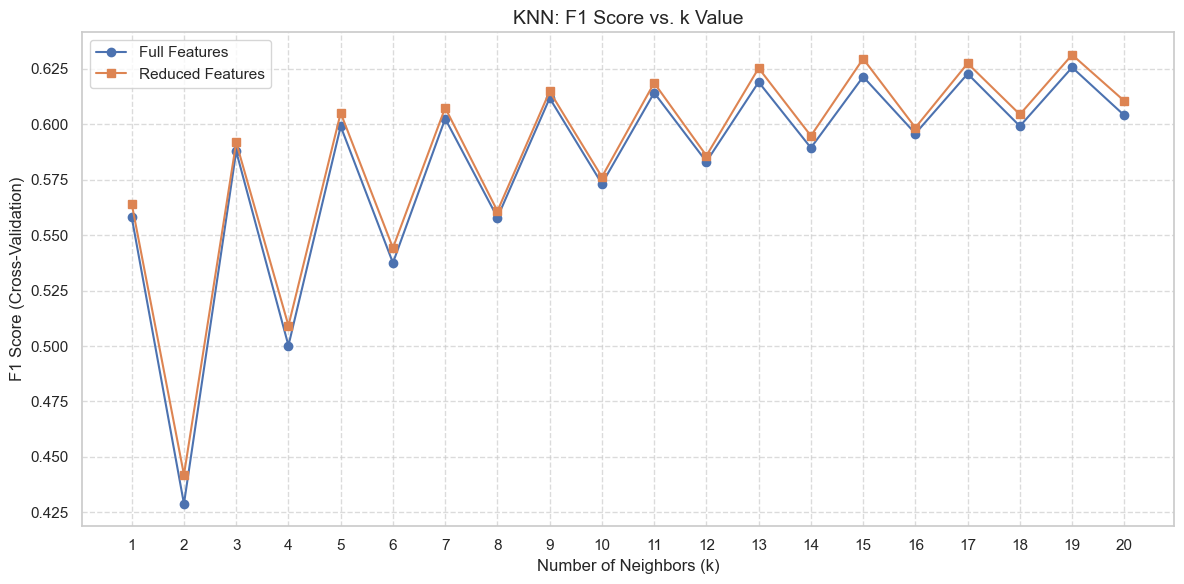

Optimal k for full feature set: 19
Optimal k for reduced feature set: 19


In [4]:
# Function to find optimal K using cross-validation
def find_optimal_k(X_train, y_train, k_range):
    k_scores = []
    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k)
        # Use 5-fold cross-validation with F1 score as the evaluation metric
        scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='f1')
        k_scores.append(scores.mean())
    return k_scores

# Range of k values to test
k_range = range(1, 21)  # Test k from 1 to 20

# Find optimal k for both feature sets
print("Finding optimal K for KNN...")
k_scores_full = find_optimal_k(X_full_train_scaled, y_full_train, k_range)
k_scores_reduced = find_optimal_k(X_reduced_train_scaled, y_reduced_train, k_range)

# Plot k values vs. performance
plt.figure(figsize=(12, 6))
plt.plot(k_range, k_scores_full, marker='o', label='Full Features')
plt.plot(k_range, k_scores_reduced, marker='s', label='Reduced Features')
plt.xlabel('Number of Neighbors (k)', fontsize=12)
plt.ylabel('F1 Score (Cross-Validation)', fontsize=12)
plt.title('KNN: F1 Score vs. k Value', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(k_range)
plt.tight_layout()
plt.show()

# Get optimal k values
optimal_k_full = k_range[np.argmax(k_scores_full)]
optimal_k_reduced = k_range[np.argmax(k_scores_reduced)]
print(f"Optimal k for full feature set: {optimal_k_full}")
print(f"Optimal k for reduced feature set: {optimal_k_reduced}")

### Interpretation of K Values

The optimal K values tell us important information about our dataset:

1. **For Full Feature Set (K = 19)**:
   - This suggests the data structure with all features requires larger neighborhood sizes for optimal prediction.

2. **For Reduced Feature Set (K = 19)**:
   - With fewer features, the model performs best with larger neighborhood sizes.

The difference between these K values reflects how feature selection impacts the local neighborhood structure that KNN uses for classification.

## 4. Training KNN Models with Optimal K Values

Now that we've identified the optimal K values, let's train KNN models for both feature sets:

In [5]:
# Function to evaluate model performance
def evaluate_model(y_true, y_pred, y_prob=None):
    """Calculate and return performance metrics for a classification model."""
    # Basic metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    # ROC AUC (if probability predictions are available)
    roc_auc = roc_auc_score(y_true, y_prob) if y_prob is not None else None
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc
    }

# Train KNN model with optimal k for full feature set
knn_full = KNeighborsClassifier(n_neighbors=optimal_k_full)
knn_full.fit(X_full_train_scaled, y_full_train)

# Train KNN model with optimal k for reduced feature set
knn_reduced = KNeighborsClassifier(n_neighbors=optimal_k_reduced)
knn_reduced.fit(X_reduced_train_scaled, y_reduced_train)

# Make predictions
y_full_pred = knn_full.predict(X_full_test_scaled)
y_reduced_pred = knn_reduced.predict(X_reduced_test_scaled)

# Get probability predictions
y_full_prob = knn_full.predict_proba(X_full_test_scaled)[:, 1]
y_reduced_prob = knn_reduced.predict_proba(X_reduced_test_scaled)[:, 1]

# Evaluate performance
full_metrics = evaluate_model(y_full_test, y_full_pred, y_full_prob)
reduced_metrics = evaluate_model(y_reduced_test, y_reduced_pred, y_reduced_prob)

# Display results
print("\nKNN Model with Full Feature Set:")
print(f"Accuracy: {full_metrics['accuracy']:.4f}")
print(f"Precision: {full_metrics['precision']:.4f}")
print(f"Recall: {full_metrics['recall']:.4f}")
print(f"F1 Score: {full_metrics['f1_score']:.4f}")
print(f"ROC AUC: {full_metrics['roc_auc']:.4f}")

print("\nKNN Model with Reduced Feature Set:")
print(f"Accuracy: {reduced_metrics['accuracy']:.4f}")
print(f"Precision: {reduced_metrics['precision']:.4f}")
print(f"Recall: {reduced_metrics['recall']:.4f}")
print(f"F1 Score: {reduced_metrics['f1_score']:.4f}")
print(f"ROC AUC: {reduced_metrics['roc_auc']:.4f}")


KNN Model with Full Feature Set:
Accuracy: 0.7242
Precision: 0.6200
Recall: 0.6335
F1 Score: 0.6267
ROC AUC: 0.8075

KNN Model with Reduced Feature Set:
Accuracy: 0.7256
Precision: 0.6188
Recall: 0.6493
F1 Score: 0.6337
ROC AUC: 0.8071


## 5. Understanding the Evaluation Metrics

To properly interpret our model performance, let's understand what each metric tells us in the context of our smoking prediction task:

1. **Accuracy**: The proportion of correct predictions (both smokers and non-smokers) among the total predictions. While this metric is intuitive, it can be misleading with imbalanced classes.

2. **Precision**: The proportion of true positive predictions (correctly identified smokers) among all positive predictions. A high precision means when the model predicts someone is a smoker, it's very likely to be correct. Low precision indicates many false alarms.

3. **Recall (Sensitivity)**: The proportion of true positive predictions (correctly identified smokers) among all actual smokers. A high recall means the model is good at finding smokers and doesn't miss many. Low recall means many smokers go undetected.

4. **F1 Score**: The harmonic mean of precision and recall, providing a balance between these two metrics. This is especially useful when we need a single metric that balances the trade-off between precision and recall.

5. **ROC AUC**: Area Under the Receiver Operating Characteristic curve, which measures the model's ability to distinguish between classes across all possible classification thresholds. Values range from 0.5 (no discriminative power) to 1.0 (perfect discrimination).

For our smoking prediction task, the relative importance of these metrics depends on the specific use case:
- If avoiding false alarms is critical (e.g., to prevent unnecessary interventions), we would prioritize precision.
- If catching all smokers is the priority (e.g., for comprehensive screening), we would focus on recall.
- For a balanced approach, F1 score and ROC AUC provide good overall assessments.

## 6. Visualizing Model Performance

Confusion Matrix for Full Feature Set:


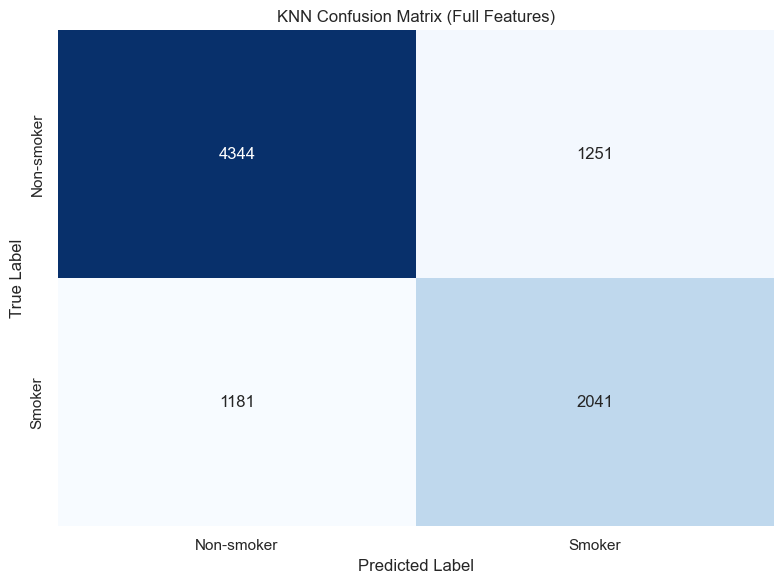

Specificity (True Negative Rate): 0.7764
Negative Predictive Value: 0.7862

Confusion Matrix for Reduced Feature Set:


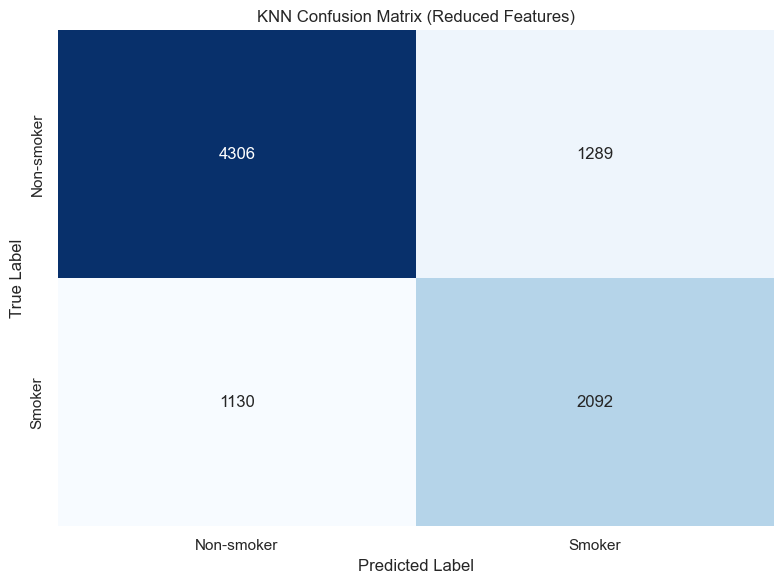

Specificity (True Negative Rate): 0.7696
Negative Predictive Value: 0.7921


In [6]:
# Function to plot confusion matrices
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
               xticklabels=['Non-smoker', 'Smoker'],
               yticklabels=['Non-smoker', 'Smoker'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.tight_layout()
    plt.show()
    
    # Calculate and display derived metrics
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)  # True negative rate
    npv = tn / (tn + fn)  # Negative predictive value
    print(f"Specificity (True Negative Rate): {specificity:.4f}")
    print(f"Negative Predictive Value: {npv:.4f}")

# Function to plot ROC curves
def plot_roc_curve(y_true, y_prob, label):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, roc_auc

# Display confusion matrices
print("Confusion Matrix for Full Feature Set:")
plot_confusion_matrix(y_full_test, y_full_pred, 'KNN Confusion Matrix (Full Features)')

print("\nConfusion Matrix for Reduced Feature Set:")
plot_confusion_matrix(y_reduced_test, y_reduced_pred, 'KNN Confusion Matrix (Reduced Features)')

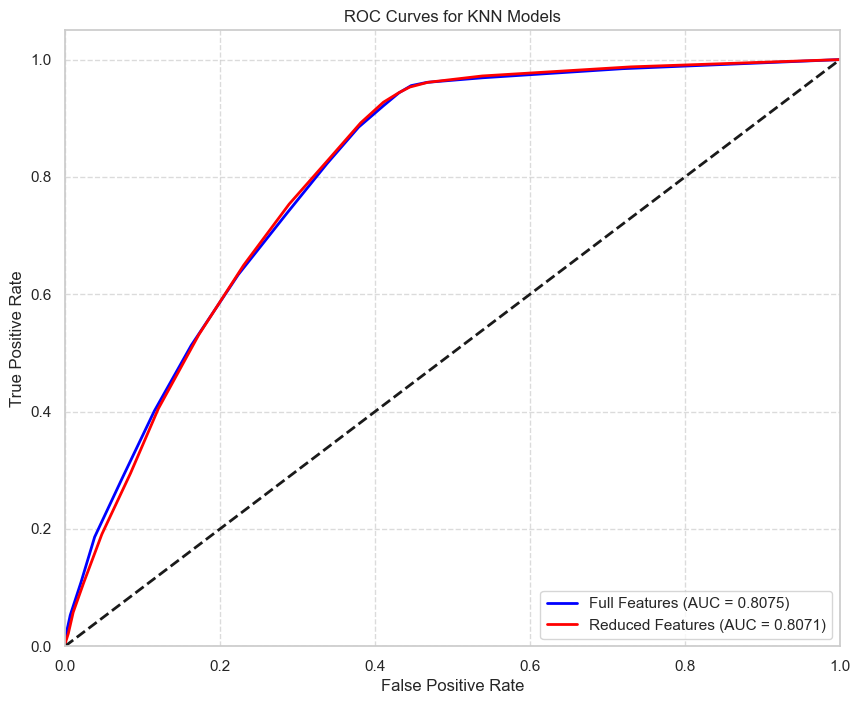

In [7]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Plot ROC curve for the full feature model
fpr_full, tpr_full, roc_auc_full = plot_roc_curve(y_full_test, y_full_prob, 'Full')
plt.plot(fpr_full, tpr_full, label=f'Full Features (AUC = {roc_auc_full:.4f})', lw=2, color='blue')

# Plot ROC curve for the reduced feature model
fpr_reduced, tpr_reduced, roc_auc_reduced = plot_roc_curve(y_reduced_test, y_reduced_prob, 'Reduced')
plt.plot(fpr_reduced, tpr_reduced, label=f'Reduced Features (AUC = {roc_auc_reduced:.4f})', lw=2, color='red')

# Plot the diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for KNN Models')
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

## 7. Comparison of Feature Sets

Let's directly compare the performance of our full and reduced feature sets to see how much predictive power we retain with fewer features:

In [8]:
# Create a comparison DataFrame
metrics_comparison = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC'],
    'Full Features': [
        full_metrics['accuracy'],
        full_metrics['precision'],
        full_metrics['recall'],
        full_metrics['f1_score'],
        full_metrics['roc_auc']
    ],
    'Reduced Features': [
        reduced_metrics['accuracy'],
        reduced_metrics['precision'],
        reduced_metrics['recall'],
        reduced_metrics['f1_score'],
        reduced_metrics['roc_auc']
    ]
})

# Calculate differences and percentage changes
metrics_comparison['Absolute Difference'] = metrics_comparison['Full Features'] - metrics_comparison['Reduced Features']
metrics_comparison['Percentage Change (%)'] = (metrics_comparison['Absolute Difference'] / metrics_comparison['Full Features']) * 100

# Display the comparison
print("Comparison of KNN Performance: Full vs. Reduced Feature Sets")
metrics_comparison.set_index('Metric')

Comparison of KNN Performance: Full vs. Reduced Feature Sets


,Full Features,Reduced Features,Absolute Difference,Percentage Change (%)
Metric,,,,
Accuracy,0.724169,0.725644,-0.001474,-0.203602
Precision,0.619988,0.618752,0.001236,0.199359
Recall,0.633457,0.649286,-0.015829,-2.498775
F1 Score,0.626650,0.633651,-0.007001,-1.117223
ROC AUC,0.807513,0.807133,0.000380,0.047080


<Figure size 1200x800 with 0 Axes>

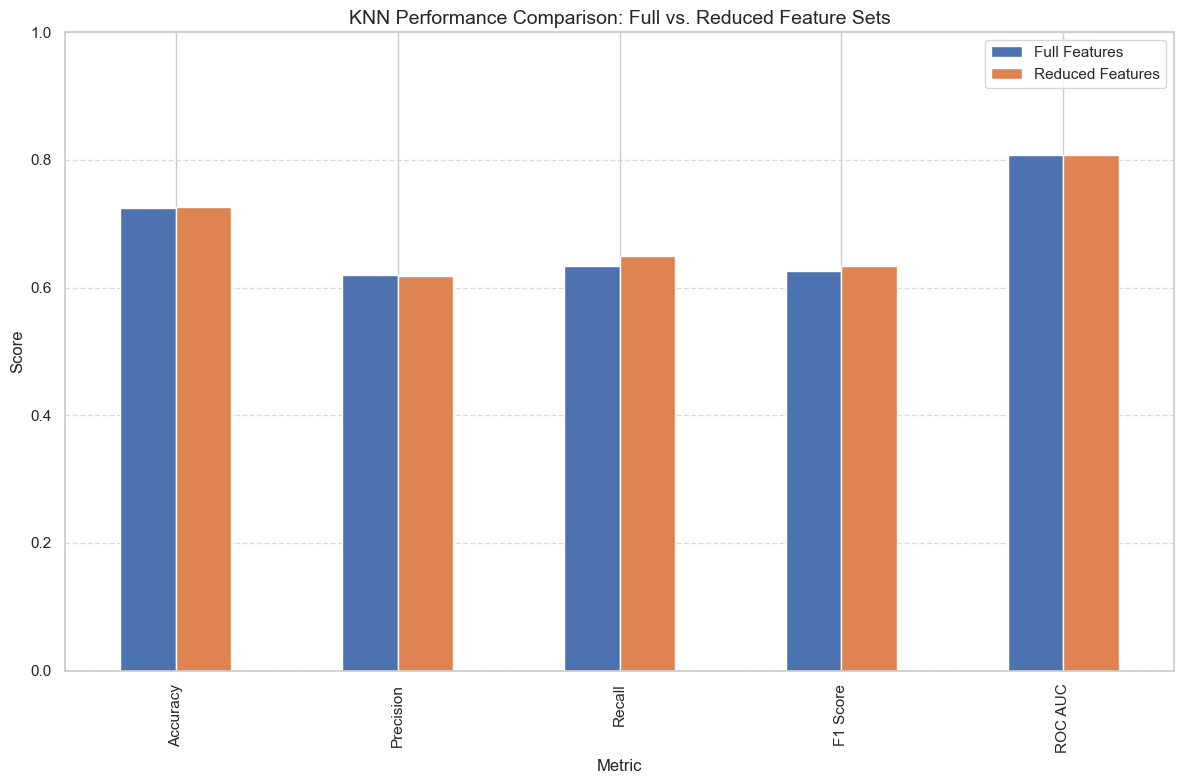

In [9]:
# Visualize the comparison
plt.figure(figsize=(12, 8))
metrics_comparison.set_index('Metric').loc[:, ['Full Features', 'Reduced Features']].plot(kind='bar')
plt.title('KNN Performance Comparison: Full vs. Reduced Feature Sets', fontsize=14)
plt.ylabel('Score', fontsize=12)
plt.ylim([0, 1])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

## 8. Save Results for Comparison with Other Models

Let's save our KNN model performance metrics to CSV files for later comparison with other models:

In [10]:
# Create DataFrames for saving results
knn_full_results = pd.DataFrame({
    'Model': ['KNN'],
    'Feature_Set': ['Full'],
    'Accuracy': [full_metrics['accuracy']],
    'Precision': [full_metrics['precision']],
    'Recall': [full_metrics['recall']],
    'F1_Score': [full_metrics['f1_score']],
    'ROC_AUC': [full_metrics['roc_auc']]
})

knn_reduced_results = pd.DataFrame({
    'Model': ['KNN'],
    'Feature_Set': ['Reduced'],
    'Accuracy': [reduced_metrics['accuracy']],
    'Precision': [reduced_metrics['precision']],
    'Recall': [reduced_metrics['recall']],
    'F1_Score': [reduced_metrics['f1_score']],
    'ROC_AUC': [reduced_metrics['roc_auc']]
})

# Combine results
knn_results = pd.concat([knn_full_results, knn_reduced_results], ignore_index=True)

# Add hyperparameter information
knn_results['Hyperparameters'] = [f"n_neighbors={optimal_k_full}", f"n_neighbors={optimal_k_reduced}"]

# Save results to CSV
knn_results.to_csv('knn_model_results.csv', index=False)
print("Saved KNN model results to knn_model_results.csv")

# Display the final results table
knn_results

Saved KNN model results to knn_model_results.csv


,Model,Feature_Set,Accuracy,Precision,Recall,F1_Score,ROC_AUC,Hyperparameters
0,KNN,Full,0.724169,0.619988,0.633457,0.626650,0.807513,n_neighbors=19
1,KNN,Reduced,0.725644,0.618752,0.649286,0.633651,0.807133,n_neighbors=19
